# Week 2 COMP188
## Dissecting Filipino family income and expenditure dataset

This week we are dissecting the [Filipino family income and expenditure dataset from Kaggle](https://www.kaggle.com/grosvenpaul/family-income-and-expenditure), with the methods used by [Google's tutorial on TensorFlow](https://developers.google.com/machine-learning/crash-course/first-steps-with-tensorflow/video-lecture). 

We'll be using TensorFlow's Linear Regressor to predict total family expediture from features of the family head as well as other family metrics.

In [1]:
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn import metrics 

import numpy as np
import pandas as pd

import math

from IPython import display
from matplotlib import cm, gridspec
from matplotlib import pyplot as plt

import os
tf.__version__ 
#I ran into problems with tensorflow being on an ancient version on my desktop's Anaconda, seems to work fine on my laptop

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.6.0'

We'll load and examine our data.

In [6]:
df = pd.read_csv('../../../data/Family Income and Expenditure.csv')

In [3]:
df.head()

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,...,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,...,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,...,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,...,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,...,1,0,0,0,0,3,0,0,0,1


I also want to get used to using pandas so I'll do some basic dataframe tasks. We'll get rid of some unnecessary data in order to run it faster and make it cleaner to look at.

We'll then sum up all the expenses, then remove all of them.

In [7]:
import re

if "Total Food Expenditure" in list(df):    
    df = df.drop("Total Food Expenditure", 1)

reg = re.compile('.*(([Ee]xpenditure)|([Ee]xpenses))$')
expenditure_types = [var for var in list(df) if re.match(reg, var)]
df["TotalExpenditure"] = np.sum(df[expenditure_types],1)

We'll also get rid of `Total Household Income` and `Number of *` because that's cheating as it would very likely highly correlate with total expenditure. 

In [8]:
reg_number = re.compile('Number.*')
reg_house = re.compile('House .*')
reg_type = re.compile('Type .*')

remove = [var for var in list(df) if re.match(reg_number, var) 
                                  or re.match(reg_house, var) 
                                  or re.match(reg_type, var)]  + expenditure_types

for var in remove:
    if var in list(df):
        df = df.drop(var, 1)

## Making the Model!
So now we wanna predict `Total Expenditures` through household parameters. Lets first shuffle the data.

In [9]:
df = df.reindex(np.random.permutation(df.index))

### Defining our feature
For just using a single predictor, we could use variables like `Imputed House Rental Value` or `Total Income from Entrepreneurial Activites` but it's effect would be a little too obvious and statistically significant. 

It would seem interesting to use `Household Head Age` as a predictor, so we'll use it as a numerical feature.

In [10]:
#I discovered that TensorFlow doesn't take white space when considering variable names
#this is meant to nuke all whitespaces 
df = df.rename(index=str, columns={var:(re.sub('[\s+]', '', var))for var in list(df)})

In [11]:
X = df[["HouseholdHeadAge"]]
X_attr = [tf.feature_column.numeric_column("HouseholdHeadAge")]

### Defining our target

In [12]:
y = df["TotalExpenditure"]

In [13]:
type(y)

pandas.core.series.Series

### Starting our Linear Regression Engine
We'll use the `GradientDescentOptimizer` to train our model.

The TensorFlow tutorial also uses gradient clipping to limit the magnitude of gradients, which would drastically over-shoot the gradient descent.

In [20]:
optim = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optim = tf.contrib.estimator.clip_gradients_by_norm(optim, 5.0)

lin_regress = tf.estimator.LinearRegressor(
    feature_columns = X_attr,
    optimizer = optim,
    model_dir = "TENSORFLOWTEMP"
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'TENSORFLOWTEMP', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000369A66DEF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Defining our input function
Our input function will process our pandas data into numpy arrays where TensorFlow can easily process them.

In [10]:
def inputer(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

## Training the Model

In [21]:
#Gotta restart the kernel or name the training or else it'll give us an IndexError
lin_regress.train(
    input_fn = lambda:inputer(X, y),
    steps = 100
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from TENSORFLOWTEMP\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 101 into TENSORFLOWTEMP\model.ckpt.
INFO:tensorflow:loss = 10878698000.0, step = 101
INFO:tensorflow:Saving checkpoints for 200 into TENSORFLOWTEMP\model.ckpt.
INFO:tensorflow:Loss for final step: 21380983000.0.


## Lets evaluate it.
We'll use MSE and RMSE to evaluate the effectiveness of the model. 

In [12]:
y_pred = lin_regress.predict(input_fn=lambda: inputer(X, y, num_epochs=1, shuffle=False))

y_pred = np.array([pred_row["predictions"][0] for pred_row in y_pred])
mse = metrics.mean_squared_error(y_pred, y)

r2 = metrics.r2_score(y, y_pred)

sum_stats = {
    "mse" : mse,
    "rmse" : math.sqrt(mse),
    "r2" : r2
            }
print("MSE: %0.3f\tRMSE: %0.3f\tR^2: %0.3f" % (sum_stats["mse"], sum_stats["rmse"], sum_stats["r2"]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from TENSORFLOWTEMP\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
MSE: 62977770642.553	RMSE: 250953.722	R^2: -1.574


In the end using household head age, has very little predictive power in determining `Total Expenditure` with an almost negligable R^2 and highly variable root mean squared error.

In [13]:
sum_stats.update({
    "min":df["TotalExpenditure"].min(),
    "max":df["TotalExpenditure"].max()
            })

print("MIN: %0.3f\tMAX: %0.3f" %(sum_stats["min"], sum_stats["max"]))

MIN: 11055.000	MAX: 4650633.000


Our RMSE doesn't really scale the range of the data, but the max value is not indiciative of the data as...    

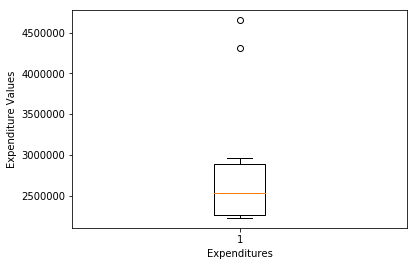

In [14]:
top10expenditures = df[["TotalExpenditure"]].sort_values(by="TotalExpenditure", ascending = False).values[:10].tolist()
top10expenditures = [expenditure[0] for expenditure in top10expenditures]

plt.boxplot(top10expenditures)
plt.xlabel("Expenditures")
plt.ylabel("Expenditure Values")
plt.show()

Our 2 most maximum values are outliers as seen by our boxplot with the next maximum value being 3,000,000.


In [15]:
print("Range between 3rd highest expenditure and lowest: %0.3f\tvs.\tRMSE: %0.3f" % (top10expenditures[2]-sum_stats["min"],
                                                                                    sum_stats["rmse"]))

Range between 3rd highest expenditure and lowest: 2944882.000	vs.	RMSE: 250953.722


Our RMSE still doesn't straddle the range, so our RMSE should be ok.

In [23]:
calib_data = pd.DataFrame()
calib_data["predictions"] = pd.Series(y_pred)
calib_data["actual"] = pd.Series(y.values)
calib_data.describe()

,predictions,actual
count,41544.000000,4.154400e+04
mean,0.002569,1.962430e+05
std,0.000708,1.564194e+05
min,0.000451,1.105500e+04
25%,0.002051,1.037790e+05
50%,0.002550,1.555070e+05
75%,0.003050,2.372878e+05
max,0.004950,4.650633e+06


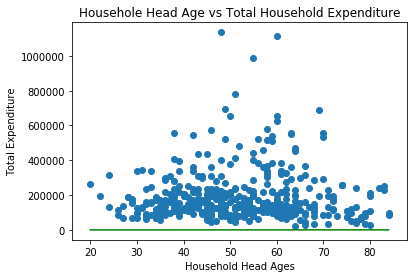

In [24]:
sample = df.sample(400)

x_0 = sample["HouseholdHeadAge"].min()
x_1 = sample["HouseholdHeadAge"].max()

weight = lin_regress.get_variable_value("linear/linear_model/HouseholdHeadAge/weights")[0]
bias = lin_regress.get_variable_value("linear/linear_model/bias_weights")

y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

plt.plot([x_0, x_1], [y_0, y_1], c='green')

plt.title("Househole Head Age vs Total Household Expenditure")
plt.ylabel("Total Expenditure")
plt.xlabel("Household Head Ages")

plt.scatter(sample["HouseholdHeadAge"], sample["TotalExpenditure"])

plt.show()

## Conclusion
The Linear Regressor is too indecisive to be significant, with clear outliers at all ages.

Therefore, Household Age cannot be a good lone predictor of `Total Expenditure`. But we may use it in conjunction with other predictors to make good predictions.

Using TensorFlow's supplied function listed below, we'll try to adjust the learning rate such that our RMSE may be better than our previous version.

In [19]:
def train_model(learning_rate, steps, batch_size, input_feature="HouseholdHeadAge"):
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = df[[my_feature]]
  my_label = "TotalExpenditure"
  targets = df[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:inputer(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: inputer(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = df.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Ollie\\AppData\\Local\\Temp\\tmpcvwisu94', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000369A608860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ollie\AppData\Local\Temp\tmpcvwisu94\model.ckpt-80
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 07 : 220053.50
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Ollie\AppData\Local\Temp\tmpcvwisu94\model.ckpt-80
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 81 into C:\Users\Ollie\AppData\Local\Temp\tmpcvwisu94\model.ckpt.
INFO:tensorflow:loss = 10549047000.0, step = 81
INFO:tensorflow:Saving checkpoints for 90 into C:\Users\Ollie\AppData\Local\Temp\tmpcvwisu94\model.ckpt.
INFO:tensorflow:Loss for final step: 233934650000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was final

,predictions,targets
count,41544.000000,0.0
mean,51390.515625,NaN
std,14162.848633,NaN
min,9019.458984,NaN
25%,41011.332031,NaN
50%,51008.792969,NaN
75%,61006.253906,NaN
max,98996.601562,NaN


Final RMSE (on training data): 212963.11


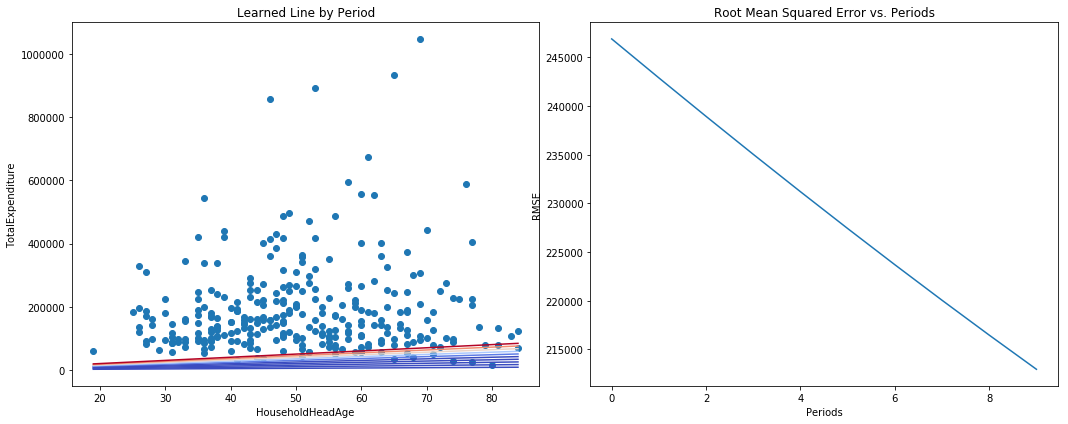

In [25]:
train_model(
    learning_rate=2,
    steps=100,
    batch_size=1
)